In [1]:
import sys

In [2]:
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install regex
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn

In [3]:
import os
import pandas as pd
import numpy as np 
from re import search

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings("ignore")

<h3>Importing the dataset</h3>

In [6]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd,'Dataset')
result_dir = os.path.join(cwd,'Results')

In [7]:
modelname = ['GBC','LR','MNB','RFC','SVC']
modelnamebase = ['GBC','LR','MNB','RFC','SVM']

In [8]:
test_res = []
train_res = []
valid_res = []

In [9]:
base_test_res = []
base_train_res = []
base_valid_res = []

<h3>Result Processing</h3>

<h4>Base</h4>

In [10]:
for model in modelnamebase:
    base_train_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Train_result.csv'))
    base_test_df = pd.read_csv(os.path.join(result_dir, f'BASE\BASE_{model}_Test_result.csv'))
    
    unnamed_columns = [col for col in base_test_df.columns if search(r'^Unnamed', col)]
    base_test_df = base_test_df.drop(unnamed_columns, axis=1)
    base_test_df.drop('Time (Sec)', axis=1, inplace=True)
    
    unnamed_columns = [col for col in base_train_df.columns if search(r'^Unnamed', col)]
    base_train_df = base_train_df.drop(unnamed_columns, axis=1)
    base_train_df.drop('Time (Sec)', axis=1, inplace=True)
    
    base_test_df.drop('ID', axis=1, inplace=True)
    base_train_df.drop('ID', axis=1, inplace=True)
    
    base_final_test_res = base_test_df.to_dict(orient='records')[0]
    base_final_test_res['Model'] = model
    base_test_res.append(base_final_test_res)
    
    base_final_train_res = base_train_df.to_dict(orient='records')[0]
    base_final_train_res['Model'] = model
    base_train_res.append(base_final_train_res)

In [11]:
for model in modelnamebase :
    file_path = os.path.join(result_dir,f'BASE\BASE_{model}_Valid_report.txt')

    with open(file_path, 'r') as file:
        classification_report_str = file.read()

    lines = classification_report_str.strip().split('\n')

    accuracy_line = lines[-3].split()[1:]
    macro_avg_line = lines[-2].split()[2:-1]

    accuracy = float(accuracy_line[0])
    macro_avg_precision, macro_avg_recall, macro_avg_f1 = map(float, macro_avg_line)
    
    base_valid_res_mdl = dict()
    base_valid_res_mdl['Accuracy'] = accuracy
    base_valid_res_mdl['F1-Score'] = macro_avg_f1
    base_valid_res_mdl['Recall'] = macro_avg_recall
    base_valid_res_mdl['Precision'] = macro_avg_precision
    base_valid_res_mdl['Model']=model
    
    base_valid_res.append(base_valid_res_mdl)

In [12]:
base_test_res_df = pd.DataFrame(base_test_res)
base_test_res_df['Model'] = base_test_res_df['Model'].astype(str)
base_test_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.923610,0.921226,0.933703,0.909124,GBC
1,0.938271,0.935821,0.940805,0.930910,LR
2,0.779387,0.701553,0.542360,0.993514,MNB
3,0.901397,0.893358,0.863458,0.925446,RFC
4,0.955449,0.953688,0.958958,0.948509,SVM


In [13]:
base_train_res_df = pd.DataFrame(base_train_res)
base_train_res_df['Model'] = base_train_res_df['Model'].astype(str)
base_train_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.938617,0.936771,0.950572,0.923365,GBC
1,0.965926,0.964425,0.965535,0.963319,LR
2,0.824251,0.775571,0.634866,0.996439,MNB
3,1.000000,1.000000,1.000000,1.000000,RFC
4,0.997829,0.997733,0.998619,0.996849,SVM


In [14]:
base_valid_res_df = pd.DataFrame(base_valid_res)
base_valid_res_df['Model'] = base_valid_res_df['Model'].astype(str)
base_valid_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.92776,0.92761,0.92809,0.92731,GBC
1,0.93657,0.93633,0.93604,0.93669,LR
2,0.80695,0.79455,0.79574,0.86391,MNB
3,0.90813,0.90745,0.90617,0.91039,RFC
4,0.95620,0.95604,0.95579,0.95635,SVM


<h4>Hyper Tuned</h4>

In [17]:
for model in modelname :
    train_df = pd.read_csv(os.path.join(result_dir,f'{model}_Train_result.csv'))
    test_df = pd.read_csv(os.path.join(result_dir,f'{model}_Test_result.csv'))
    parameter_df = pd.read_csv(os.path.join(result_dir,f'{model}_Parameters.csv'))
    
    unnamed_columns = [col for col in test_df.columns if search(r'^Unnamed', col)]
    test_df = test_df.drop(unnamed_columns, axis=1)
    test_columns = list(test_df.columns)
    
    test_top_ten = pd.DataFrame()
    test_top_ten = test_top_ten.append(test_df.nlargest(10, ['Accuracy']), ignore_index = True)
    test_top_ten.columns = test_columns
    test_top_ten.drop('Time (Sec)', axis=1, inplace=True)
    
    #print('Test')
    #print(test_top_ten)
    ID_list = list(test_top_ten['ID'])
    
    unnamed_columns = [col for col in train_df.columns if search(r'^Unnamed', col)]
    train_df = train_df.drop(unnamed_columns, axis=1)
    train_columns = list(train_df.columns)
    
    train_ten = pd.DataFrame()
    for ID in ID_list :
        train_ten = train_ten.append([train_df[train_df.ID == ID]], ignore_index = True)
    train_ten.columns = train_columns
    train_ten.drop('Time (Sec)', axis=1, inplace=True)
    
    #print('Train')
    #print(train_ten)
    
    unnamed_columns = [col for col in parameter_df.columns if search(r'^Unnamed', col)]
    parameter_df = parameter_df.drop(unnamed_columns, axis=1)
    parameter_columns = list(parameter_df.columns)
    
    parameter_ten = pd.DataFrame()
    for ID in ID_list :
        parameter_ten = parameter_ten.append([parameter_df[parameter_df.ID == ID]], ignore_index = True)
    parameter_ten.columns = parameter_columns
    
    print(f'Parameters {model}')
    print(parameter_ten)
    
    final_test_res = dict(test_top_ten.mean())
    final_test_res['Model'] = model
    test_res.append(final_test_res)
    
    final_train_res = dict(train_ten.mean())
    final_train_res['Model'] = model
    train_res.append(final_train_res)

Parameters GBC
   random_state  n_estimators  min_samples_split  min_samples_leaf  \
0          1973           500               73.0              20.0   
1          1973           450               38.0              35.0   
2          1973           500               81.0              61.0   
3          1973           550                2.0              80.0   
4          1973           500               20.0              29.0   
5          1973           450               25.0              69.0   
6          1973           550               47.0              75.0   
7          1973           250               98.0              41.0   
8          1973           500               51.0              77.0   
9          1973           550                0.5               2.0   

  max_features  max_depth  learning_rate     criterion        ID  
0         sqrt         24           0.09  friedman_mse  GBC-0070  
1         sqrt         92           0.09  friedman_mse  GBC-0065  
2         sqr

In [18]:
for model in modelname :
    file_path = os.path.join(result_dir,f'{model}_Valid_report.txt')

    with open(file_path, 'r') as file:
        classification_report_str = file.read()

    lines = classification_report_str.strip().split('\n')

    accuracy_line = lines[-3].split()[1:]
    macro_avg_line = lines[-2].split()[2:-1]

    accuracy = float(accuracy_line[0])
    macro_avg_precision, macro_avg_recall, macro_avg_f1 = map(float, macro_avg_line)
    
    valid_res_mdl = dict()
    valid_res_mdl['Accuracy'] = accuracy
    valid_res_mdl['F1-Score'] = macro_avg_f1
    valid_res_mdl['Recall'] = macro_avg_recall
    valid_res_mdl['Precision'] = macro_avg_precision
    valid_res_mdl['Model']=model
    
    valid_res.append(valid_res_mdl)

In [19]:
test_res_df = pd.DataFrame(test_res)
test_res_df['Model'] = test_res_df['Model'].astype(str)
test_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.962094,0.960448,0.962260,0.958699,GBC
1,0.957860,0.956082,0.958827,0.953369,LR
2,0.896055,0.881730,0.811406,0.966009,MNB
3,0.874686,0.864276,0.834794,0.896019,RFC
4,0.957948,0.956163,0.958695,0.953675,SVC
5,0.962094,0.960448,0.962260,0.958699,GBC


In [20]:
train_res_df = pd.DataFrame(train_res)
train_res_df['Model'] = train_res_df['Model'].astype(str)
train_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.999637,0.999620,0.999980,0.999261,GBC
1,0.999998,0.999998,0.999997,1.000000,LR
2,0.958594,0.954961,0.920886,0.991983,MNB
3,0.934303,0.930666,0.926309,0.935240,RFC
4,0.999580,0.999561,0.999549,0.999573,SVC
5,0.999637,0.999620,0.999980,0.999261,GBC


In [21]:
valid_res_df = pd.DataFrame(valid_res)
valid_res_df['Model'] = valid_res_df['Model'].astype(str)
valid_res_df.head(6)

,Accuracy,F1-Score,Recall,Precision,Model
0,0.95872,0.95858,0.95848,0.95869,GBC
1,0.95469,0.95455,0.95447,0.95463,LR
2,0.91140,0.91021,0.90781,0.91931,MNB
3,0.91040,0.90980,0.90868,0.91214,RFC
4,0.95998,0.95984,0.95970,0.96000,SVC


<h3>Graphing</h3>

In [22]:
graph_dir = os.path.join(cwd,'Graphs')

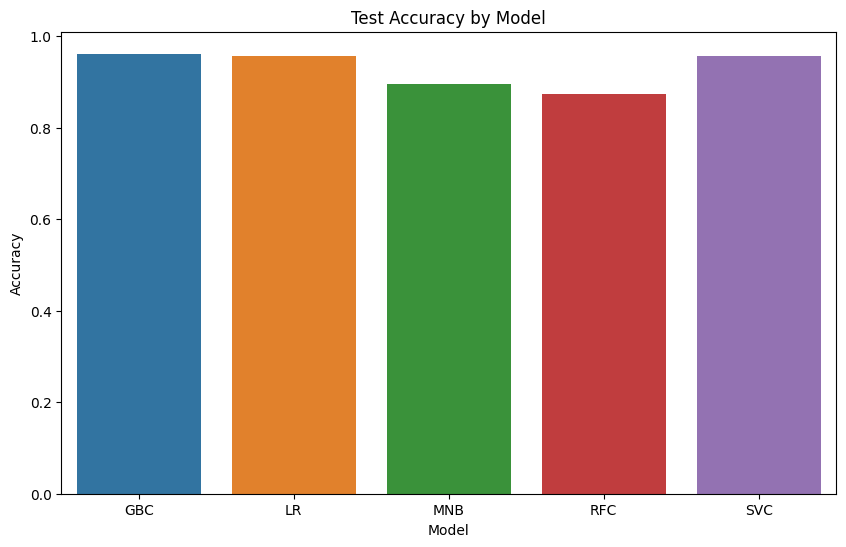

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=test_res_df)
title = 'Test Accuracy by Model'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

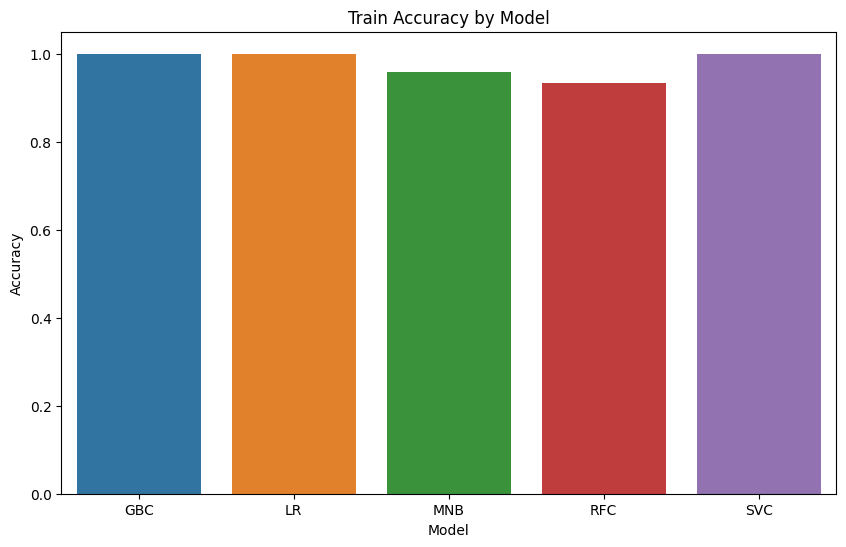

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=train_res_df)
title='Train Accuracy by Model'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()

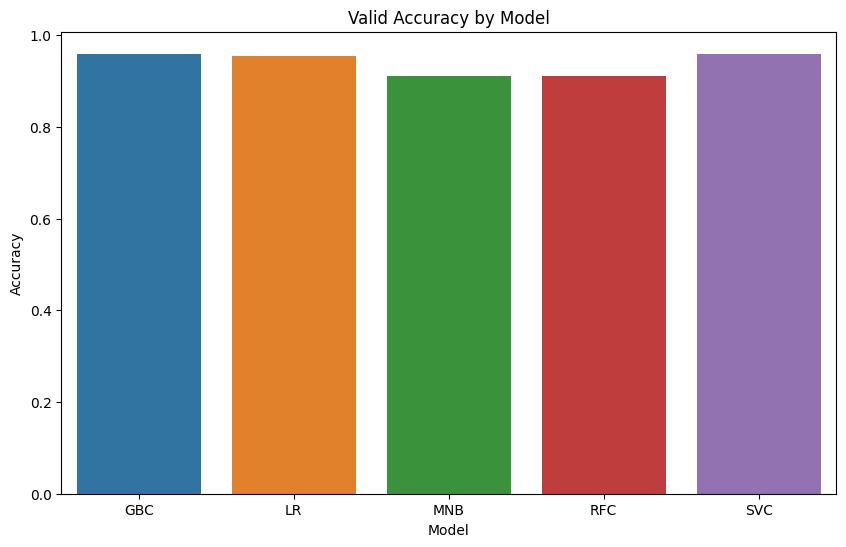

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=valid_res_df)
title='Valid Accuracy by Model'
plt.title(title)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
plt.show()
plt.close()